In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [31]:
with open("Data/processed_df.pkl", "rb") as f:
    df = pickle.load(f)

print(df.shape)

(404287, 6)


In [32]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [33]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    pattern = re.compile('<.*?>')
    q =  pattern.sub(r'',q)
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

* In this section, we create seven informative features from the preprocessed columns. These features help quantify the similarity between each question pair, which is crucial for identifying duplicates.

    q1_len – Number of characters in question1

    q2_len – Number of characters in question2

    q1_num_words – Number of words in question1

    q2_num_words – Number of words in question2

    word_common – Count of common words between both questions

    word_total – Total number of unique words across both questions

    word_share – Ratio of common to total words (similarity score)

In [34]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [35]:
df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

In [36]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [37]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

df['word_common'] = df.apply(common_words, axis=1)

In [38]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

df['word_total'] = df.apply(total_words, axis=1)

In [39]:
df['word_share'] = round(df['word_common']/df['word_total'],2)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,23,0.48
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8,26,0.31
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,24,0.17
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,1,22,0.05
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,4,21,0.19


# Advanced Features
1. Token Features:

    - cwc_min: This is the ratio of the number of common words to the length of the smaller question.
    - cwc_max: This is the ratio of the number of common words to the length of the larger question.
    - csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions.
    - csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions.
    - ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions.
    - ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions.
    - last_word_eq: 1 if the last word in the two questions is same, 0 otherwise.
    - first_word_eq: 1 if the first word in the two questions is same, 0 otherwise.

In [40]:
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
     
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [41]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

2. Length Based Features:

    - mean_len: Mean of the length of the two questions (number of words).
    - abs_len_diff: Absolute difference between the length of the two questions (number of words).
    - longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question.


In [49]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    if strs:
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        length_features[2] = 0.0

    
    return length_features

In [50]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

3. Fuzzy Features:

    we generate additional similarity-based features using the fuzzywuzzy library. These features help capture textual similarities between preprocessed question pairs, even when the wording or order differs slightly.
    - fuzz_ratio: Computes the overall Levenshtein distance similarity between the two questions.
    - fuzz_partial_ratio: Measures the similarity of the most matching substring, useful for partially overlapping text.
    - token_sort_ratio: Compares the questions after sorting tokens alphabetically, making it order-insensitive.
    - token_set_ratio: Measures similarity based on common tokens, focusing on meaningful overlaps while ignoring stop words or extra tokens.

In [53]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4

    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [54]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [55]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,0.785709,0.0,1.0,2.0,13.0,0.982456,93,100,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,...,0.466664,0.0,1.0,5.0,12.5,0.588235,66,74,63,86
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,0.285712,0.0,1.0,4.0,12.0,0.169492,43,46,63,63
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,...,0.000000,0.0,0.0,1.0,11.5,0.040000,9,11,25,28
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,...,0.307690,0.0,1.0,6.0,10.0,0.153846,35,55,47,67


### Pairwise Feature Relationships

The plot below shows pairwise scatter plots for the features `ctc_min`, `cwc_min`, and `csc_min`, colored by the `is_duplicate` label.

- It helps us observe how these features interact with each other.
- Useful to identify separation patterns between duplicate and non-duplicate pairs.
- Visual clues like clustering, separation, or overlap can help understand feature importance.


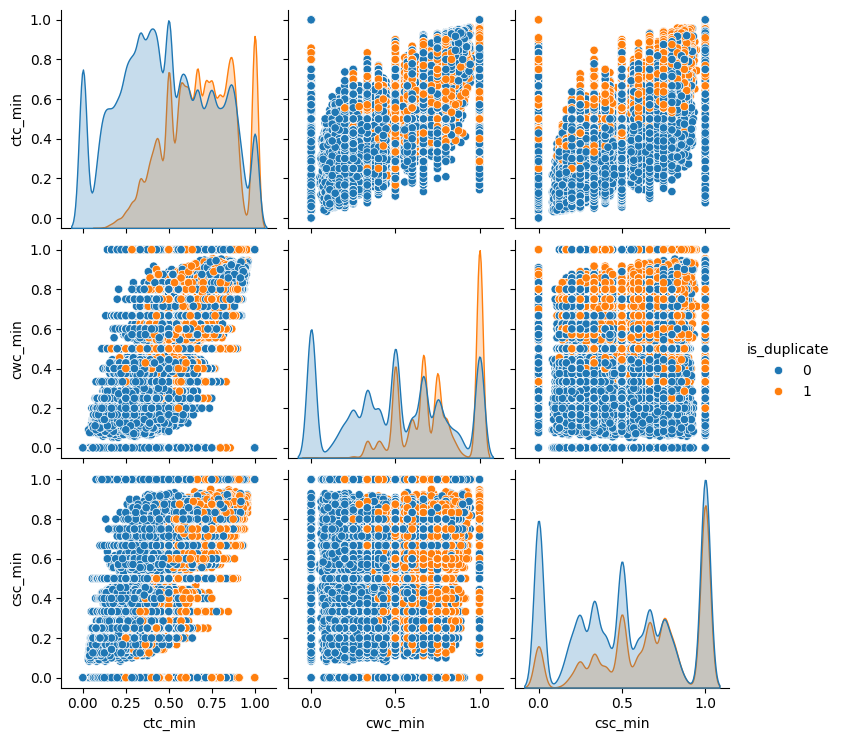

In [57]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']], hue='is_duplicate')

### Pairwise Relationship of Maximum Overlap Features

This plot visualizes pairwise relationships between the following features:
- `ctc_max` (Common Token Count - Max)
- `cwc_max` (Common Word Count - Max)
- `csc_max` (Common Character Count - Max)

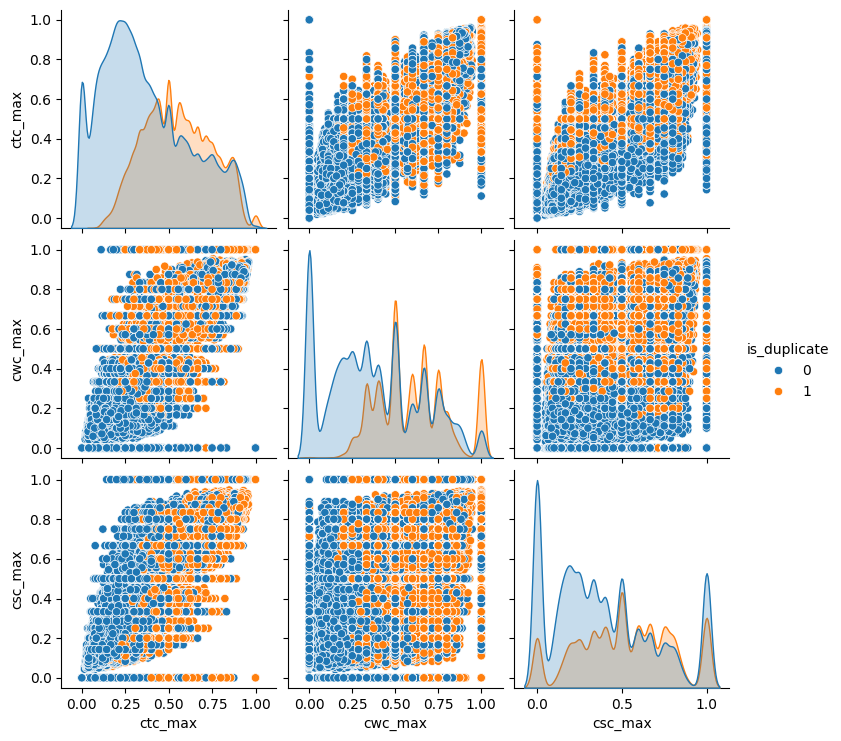

In [58]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']], hue='is_duplicate')

### First and Last Word Match Analysis

This pairplot shows how the equality of first and last words in question pairs relates to their duplication status.

- `first_word_eq`: 1 if both questions start with the same word, else 0.
- `last_word_eq`: 1 if both questions end with the same word, else 0.

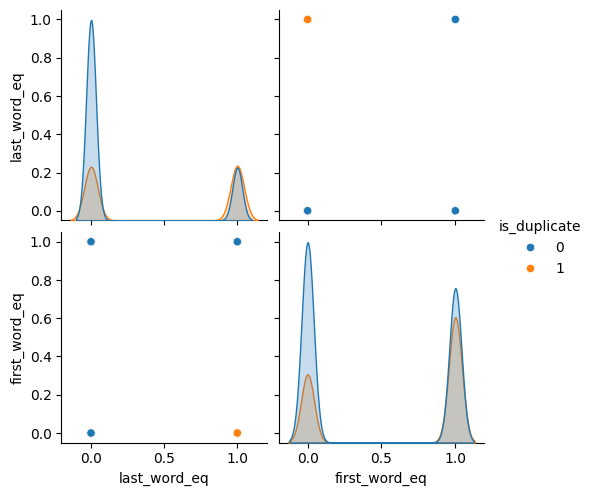

In [59]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

### Length-Based Feature Relationships

This pairplot visualizes the relationship between length-based features and question duplication:

- Duplicate questions tend to have similar lengths (`abs_len_diff` is low).
- Higher `longest_substr_ratio` is often associated with duplicate pairs.
- Length features provide useful signals for determining duplication.

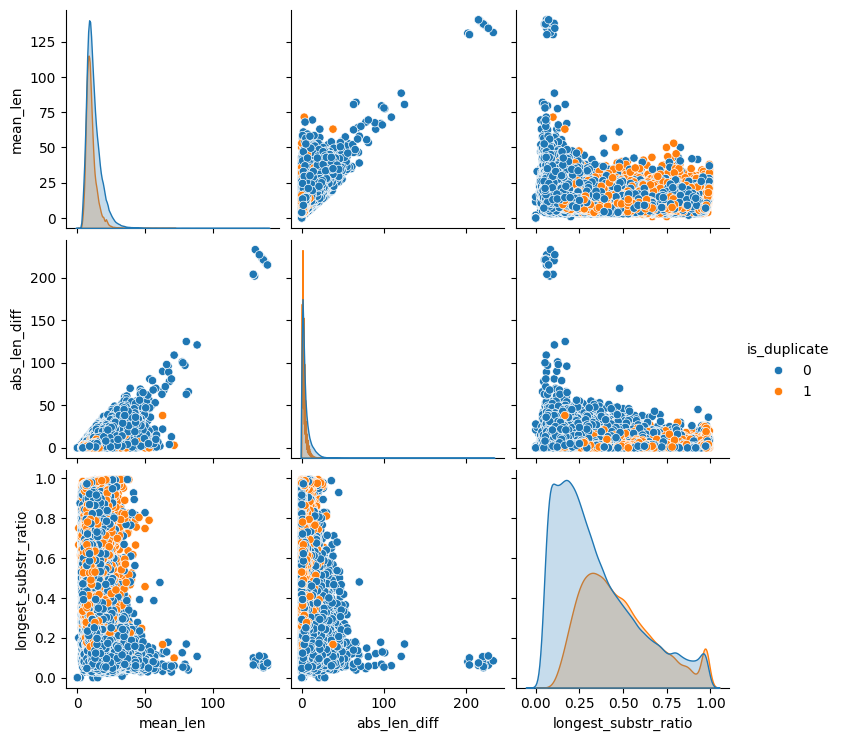

In [60]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

- From the above pairplot, it is clear that the features mean_len and abs_len_diff do not show significant separation between duplicate and non-duplicate classes.
- These features may not contribute much to model performance.
- These features can be safely dropped from the final feature set to reduce noise and improve model efficiency.


In [64]:
df.drop(columns = ['mean_len', 'abs_len_diff'], inplace = True)

### Fuzzy Matching Feature Relationships

This pairplot shows the relationship between fuzzy string similarity metrics and question duplication:
- Higher fuzzy scores generally indicate a greater chance of the questions being duplicates.
- These features are helpful in detecting paraphrased duplicates or reworded questions.

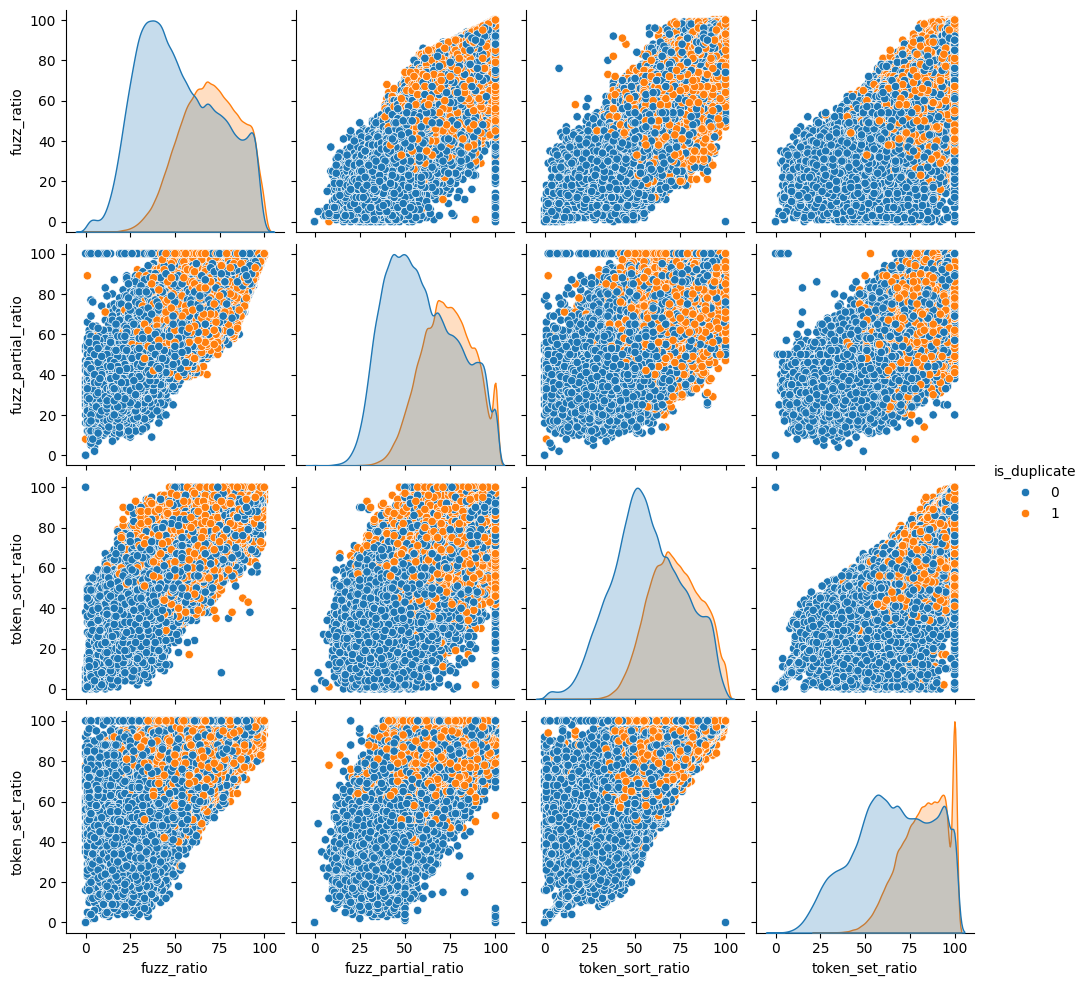

In [61]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [62]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,0.785709,0.0,1.0,2.0,13.0,0.982456,93,100,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,...,0.466664,0.0,1.0,5.0,12.5,0.588235,66,74,63,86
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,0.285712,0.0,1.0,4.0,12.0,0.169492,43,46,63,63
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,...,0.000000,0.0,0.0,1.0,11.5,0.040000,9,11,25,28
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,...,0.307690,0.0,1.0,6.0,10.0,0.153846,35,55,47,67


In [ ]:
X = MinMaxScaler().fit_transform(df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' ,
                                     'last_word_eq', 'first_word_eq', 'token_set_ratio' , 'token_sort_ratio' ,
                                     'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = df['is_duplicate'].values

- This code applies t-SNE (t-Distributed Stochastic Neighbor Embedding) for dimensionality reduction and visualization of high-dimensional data.
over subset of data(10000 rows).

In [70]:
X_sample, _, y_sample, _ = train_test_split(X, y, stratify=y, test_size=0.98, random_state=42)

In [71]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random',
    random_state=101,
    method='barnes_hut',
    max_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8085 samples in 0.022s...
[t-SNE] Computed neighbors for 8085 samples in 0.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8085
[t-SNE] Computed conditional probabilities for sample 2000 / 8085
[t-SNE] Computed conditional probabilities for sample 3000 / 8085
[t-SNE] Computed conditional probabilities for sample 4000 / 8085
[t-SNE] Computed conditional probabilities for sample 5000 / 8085
[t-SNE] Computed conditional probabilities for sample 6000 / 8085
[t-SNE] Computed conditional probabilities for sample 7000 / 8085
[t-SNE] Computed conditional probabilities for sample 8000 / 8085
[t-SNE] Computed conditional probabilities for sample 8085 / 8085
[t-SNE] Mean sigma: 0.109461
[t-SNE] Computed conditional probabilities in 0.144s
[t-SNE] Iteration 50: error = 91.2992706, gradient norm = 0.0659227 (50 iterations in 1.221s)
[t-SNE] Iteration 100: error = 75.6886597, gradient norm = 0.0112868 (50 iterations in 1.

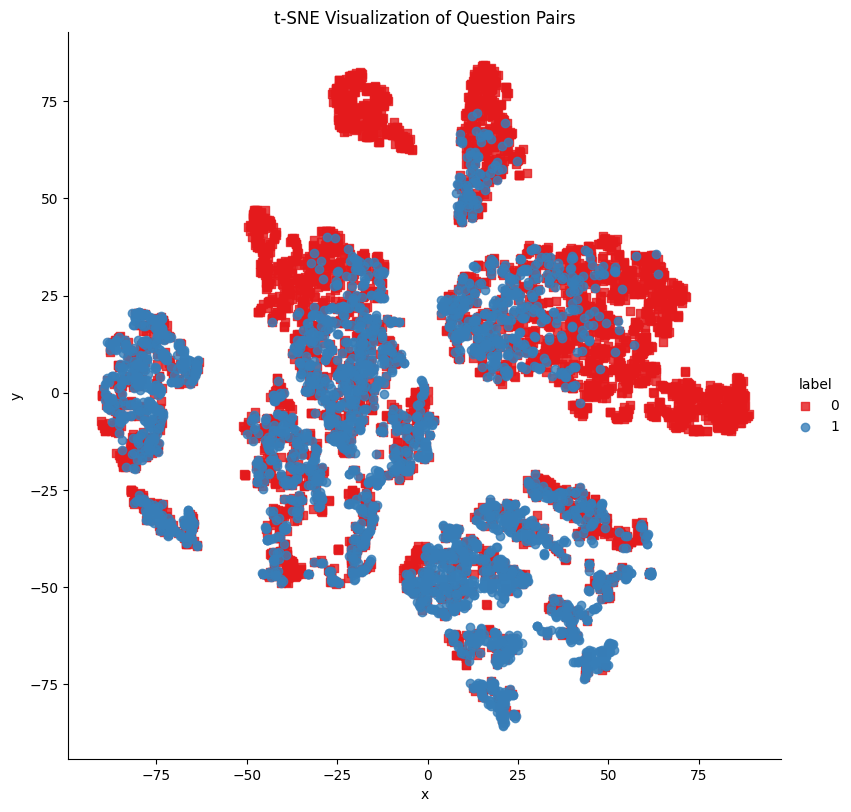

In [74]:
x_df = pd.DataFrame({
    'x': tsne2d[:, 0],
    'y': tsne2d[:, 1],
    'label': pd.Series(y_sample).reset_index(drop=True)
})

sns.lmplot(
    data=x_df,
    x='x',
    y='y',
    hue='label',
    fit_reg=False,
    height=8,             
    palette="Set1",
    markers=['s', 'o']
)

plt.title("t-SNE Visualization of Question Pairs")
plt.show()

In [75]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water


In [ ]:
engineered_features = df[['word_common', 'word_share', 'q1_len', 'q2_len', 'word_total', 'q1_num_words', 'q2_num_words',
                          'cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq',
                          'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio' ]].values
scaler = MinMaxScaler()
engineered_features = scaler.fit_transform(engineered_features)

In [84]:
questions = list(ques_df['question1'].astype(str)) + list(ques_df['question2'].astype(str))

tfidf = TfidfVectorizer(max_features=3000)
tfidf.fit(questions[:50000])  

batch_size = 50000
sparse_batches = []

for i in range(0, len(questions), batch_size):
    batch = questions[i:i+batch_size]
    X_batch = tfidf.transform(batch)  
    sparse_batches.append(X_batch)

full_sparse_matrix = vstack(sparse_batches)

n = len(ques_df)
q1_sparse = full_sparse_matrix[:n]
q2_sparse = full_sparse_matrix[n:]

print(f"q1 shape: {q1_sparse.shape}, q2 shape: {q2_sparse.shape}")

q1 shape: (404287, 3000), q2 shape: (404287, 3000)


In [85]:
from scipy.sparse import hstack, csr_matrix

engineered_sparse = csr_matrix(engineered_features)

X = hstack([q1_sparse, q2_sparse, engineered_sparse])
y = df['is_duplicate'].astype(int)

In [86]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [87]:
X_train.shape

(323429, 6020)

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

 Model: Logistic Regression
 Accuracy:  0.7938
 Precision: 0.7317
 Recall:    0.6961
 F1 Score:  0.7134


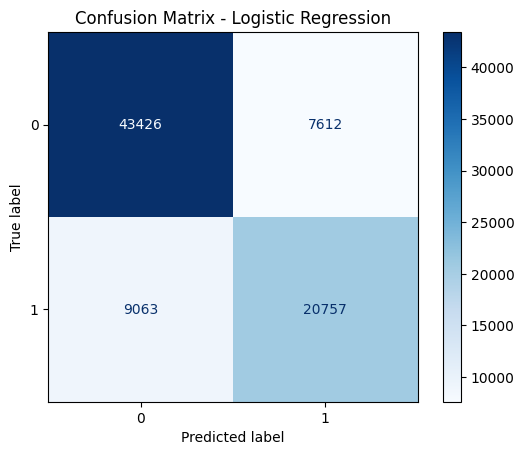

 Model: Random Forest
 Accuracy:  0.8303
 Precision: 0.7779
 Recall:    0.7556
 F1 Score:  0.7666


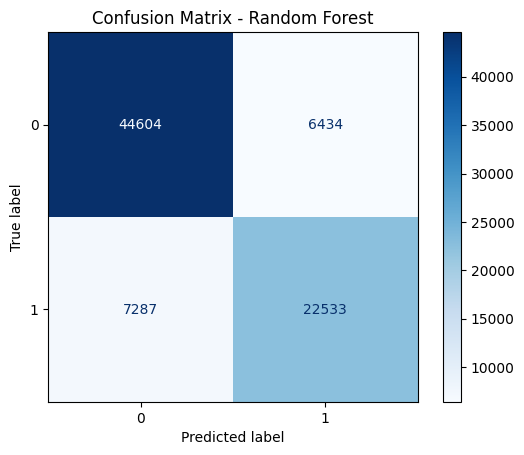

 Model: AdaBoost
 Accuracy:  0.7202
 Precision: 0.6349
 Recall:    0.5678
 F1 Score:  0.5995


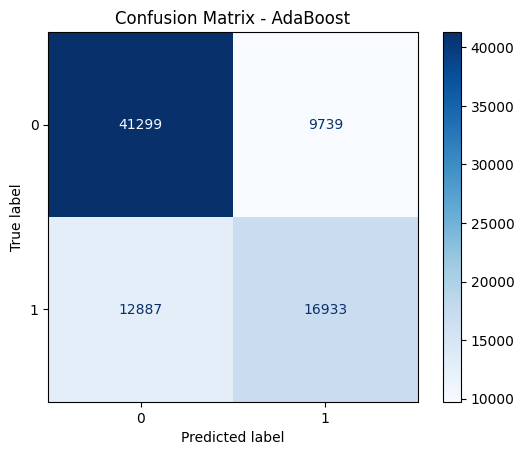

 Model: XGBoost
 Accuracy:  0.8095
 Precision: 0.7436
 Recall:    0.7381
 F1 Score:  0.7408


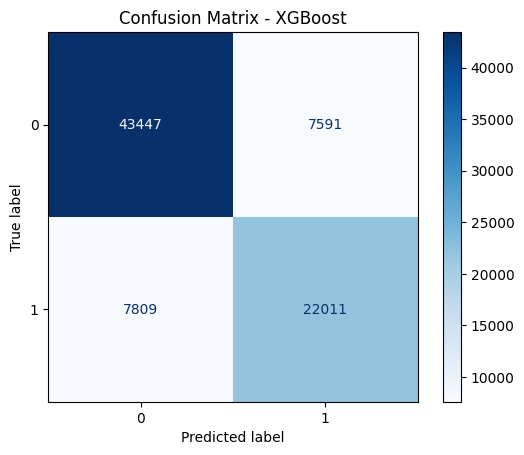

In [92]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

model_names = []
f1_scores = []
results = []

for name, model in models.items():
    
    if name == "XGBoost":
        # Convert to CSR format
        X_train_csr = X_train.tocsr()
        X_test_csr = X_test.tocsr()
        model.fit(X_train_csr, y_train)
        y_pred = model.predict(X_test_csr)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model_names.append(name)
    f1_scores.append(f1)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4)
    })

    print(f" Model: {name}")
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")
    print("="*40)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)
    plt.show()

In [93]:
results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.7938,0.7317,0.6961,0.7134
1,Random Forest,0.8303,0.7779,0.7556,0.7666
2,AdaBoost,0.7202,0.6349,0.5678,0.5995
3,XGBoost,0.8095,0.7436,0.7381,0.7408


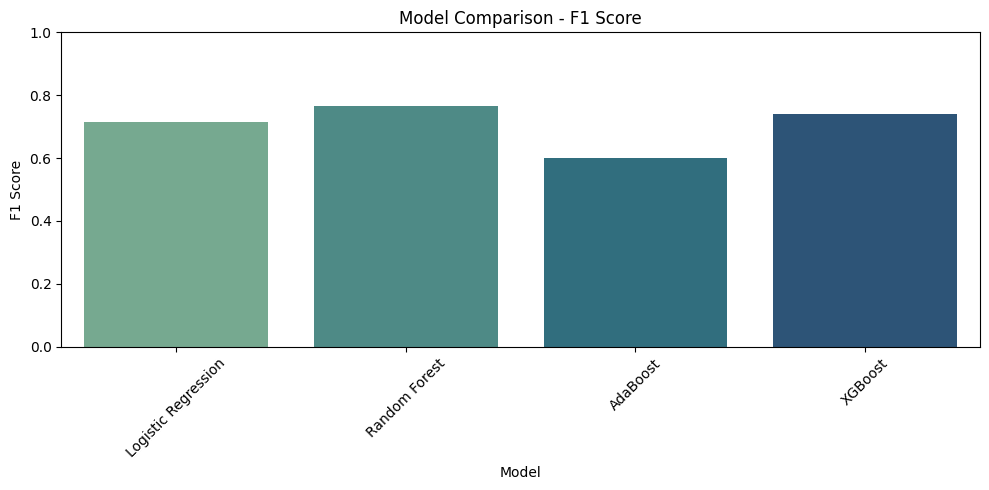

In [94]:
results_df = pd.DataFrame({'Model': model_names, 'F1 Score': f1_scores})

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='F1 Score', hue='Model', data=results_df, palette="crest", legend=False)
plt.title("Model Comparison - F1 Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [110]:
best_model_name = results_df.loc[results_df['F1 Score'].idxmax(), 'Model']
print(f"Best Model Selected: {best_model_name}")

best_model = models[best_model_name]

Best Model Selected: Random Forest


In [115]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [116]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [117]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [125]:
def test_fetch_length_features(q1, q2):
    try:
        strs = list(distance.lcsubstrings(q1, q2))
        longest_substr_ratio = len(strs[0]) / (min(len(q1), len(q2)) + 1) if strs else 0.0
    except:
        longest_substr_ratio = 0.0

    return [longest_substr_ratio]


In [119]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [127]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    q1_bow = tfidf.transform([q1]).toarray()
    q2_bow = tfidf.transform([q2]).toarray()

    
    return np.hstack((np.array(input_query).reshape(1,20),q1_bow,q2_bow))

In [121]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [128]:
features = query_point_creator(q1, q2)
prediction = best_model.predict(features)

if prediction[0] == 1:
    print("These questions are likely duplicates.")
else:
    print("These questions are not duplicates.")

These questions are not duplicates.


In [130]:
with open("models/best_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

with open("models/tfidf.pkl", "wb") as vec_file:
    pickle.dump(tfidf, vec_file)

In [129]:
with open("Data/featured_df.pkl", "wb") as f:
    pickle.dump(df, f)